# Data Analysis 3 - Assignment 1
## Predicting airbnb house prices in Spain - Data Preparation and Cleaning
Author: Borbala Kovacs

Date: 2/2/2026

**Summary:**
- **Data source**: Inside Airbnb Madrid Q1 2025 (25,285 listings → 18,688 after cleaning)
- **Target variable**: Nightly price in EUR, filtered to €0-1000 to remove outliers and inactive listings
- **Property filtering**: Simplified property types to Apartment/House/Room categories, excluding hotels, hostels, and other non-standard accommodations to focus on comparable rental units
- **Feature engineering**: Created 72 variables including log/squared transformations for non-linear relationships (accommodates, beds, days_since), extracted 31 amenity dummies from JSON, and derived categorical bins for bathrooms, reviews, and minimum nights
- **Missing value strategy**: Flagged then median-imputed review-related variables (~20% missing), extracted bathroom counts from text field, and imputed beds/bedrooms with median values



In [1]:
import os
import sys
import warnings
import json 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")

In [2]:
# Current code folder
current_path = os.getcwd()

# Get the assignment1 folder
if "code" in current_path:
    assignment_dir = os.path.dirname(current_path)
else:
    assignment_dir = current_path

# Location folders
data_in = os.path.join(assignment_dir, "data", "raw/")
data_out = os.path.join(assignment_dir, "data", "clean/")
output = os.path.join(assignment_dir, "output/")

#### Loading the data and basic descriptive stats
-------------------------------------------

In [3]:
# Read the data
df = pd.read_csv(data_in + "listings_madrid_25q1.csv")

# Basic info
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")

# Get all variable names with their data types and non-null counts
print("Variable names and info:")
print("-" * 50)
df.info()

# Preview first few rows
print("First 3 rows preview:")
df.head(3)

Shape: 25288 rows, 79 columns

Variable names and info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25288 entries, 0 to 25287
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            25288 non-null  int64  
 1   listing_url                                   25288 non-null  object 
 2   scrape_id                                     25288 non-null  int64  
 3   last_scraped                                  25288 non-null  object 
 4   source                                        25288 non-null  object 
 5   name                                          25288 non-null  object 
 6   description                                   24375 non-null  object 
 7   neighborhood_overview                         11218 non-null  object 
 8   picture_url                  

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,https://www.airbnb.com/rooms/21853,20250305023340,2025-03-11,city scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,4.82,4.21,4.67,NaN,f,2,0,2,0,0.26
1,30320,https://www.airbnb.com/rooms/30320,20250305023340,2025-03-10,previous scrape,Great Vacational Apartments,NaN,NaN,https://a0.muscache.com/pictures/336868/f67409...,130907,...,4.78,4.90,4.69,NaN,f,3,3,0,0,0.96
2,30959,https://www.airbnb.com/rooms/30959,20250305023340,2025-03-10,previous scrape,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,NaN,https://a0.muscache.com/pictures/78173471/835e...,132883,...,4.63,4.88,4.25,NaN,f,1,1,0,0,0.07


#### Clean price data: transform to numerical, drop missing and extreme values

In [4]:
# CLEAN PRICE (TARGET)
print(df.price.describe())
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df = df[(df['price'].notna()) & (df['price'] > 0) & (df['price'] < 1000)]
print(f"After price filter: {df.shape[0]} rows")


count      19274
unique       665
top       $80.00
freq         223
Name: price, dtype: object
After price filter: 19179 rows


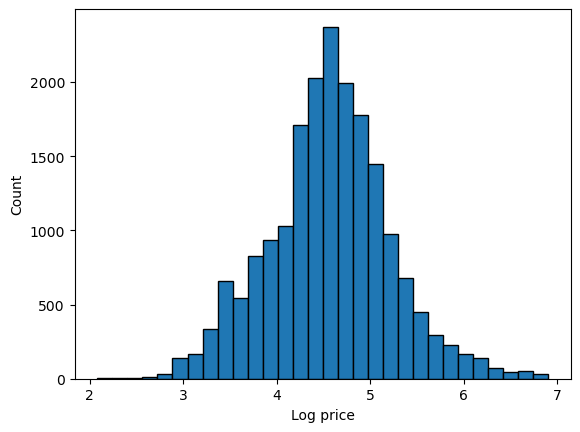

In [5]:
df["ln_price"] = np.log(df.price)
sns.histplot(df, x="ln_price", bins=30, alpha=1)
plt.ylabel("Count")
plt.xlabel("Log price")
plt.show()

#### Simplify property type variable (room, apartment, house, other)

In [6]:
# PROPERTY TYPE - simplify to Apartment/House/Other
def simplify_property(pt):
    if pd.isna(pt):
        return 'Other'
    pt = pt.lower()
    if any(x in pt for x in ['apartment', 'rental unit', 'condo', 'loft', 'serviced']):
        return 'Apartment'
    if any(x in pt for x in ['house', 'home', 'townhouse', 'villa', 'cottage', 'bungalow', 'cabin']):
        return 'House'
    return 'Other'

df['f_property_type'] = df['property_type'].apply(simplify_property).astype('category')

# Exclude hotels and hostels
df = df[~df['property_type'].str.lower().str.contains('hotel|hostel', na=False)]

print(f"After excluding hotels/hostels: {df.shape[0]} rows")

After excluding hotels/hostels: 18688 rows


#### Set variable type as categories

In [7]:
# FACTOR VARIABLES
# print(df['room_type'].unique())
# print(df['neighbourhood_cleansed'].unique())
df = df[~df['room_type'].str.lower().str.contains('hotel|hostel', na=False)]
df['f_room_type'] = df['room_type'].astype('category')
print(df['f_room_type'].value_counts())

# Keep only neighbourhoods with at least 30 observations (cross validation will not run otherwise)
neighbourhood_counts = df['neighbourhood_cleansed'].value_counts()
keep_neighbourhoods = neighbourhood_counts[neighbourhood_counts >= 30].index
df = df[df['neighbourhood_cleansed'].isin(keep_neighbourhoods)]
df['f_neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype('category')
df['f_neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype('category')

f_room_type
Entire home/apt    13790
Private room        4847
Shared room           48
Name: count, dtype: int64


#### Creating numberical values (accomodates, beds, bedrooms, bathrooms, etc.)

In [8]:
# NUMERICAL VARIABLES (there are some nan for bedrooms,beds and bathrooms as well)  
df['n_accommodates'] = df['accommodates'].astype(float)
df['n_bedrooms'] = df['bedrooms'].astype(float)
df['n_beds'] = df['beds'].astype(float)
df['n_bathrooms'] = df['bathrooms'].astype(float)

# Fill missing bathrooms from bathrooms_text (impute missing values from another source)
mask = df['n_bathrooms'].isna() & df['bathrooms_text'].notna()
df.loc[mask, 'n_bathrooms'] = df.loc[mask, 'bathrooms_text'].str.extract(r'(\d+\.?\d*)')[0].astype(float)

# Other numerical variables
df['n_number_of_reviews'] = df['number_of_reviews'].astype(float)
df['n_reviews_per_month'] = df['reviews_per_month'].astype(float)
df['n_review_scores_rating'] = df['review_scores_rating'].astype(float)
df['n_minimum_nights'] = df['minimum_nights'].astype(float)
df['n_availability_365'] = df['availability_365'].astype(float)
df['n_host_listings_count'] = df['host_listings_count'].astype(float)

# Host response rate (stored as "100%")
df['p_host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float)

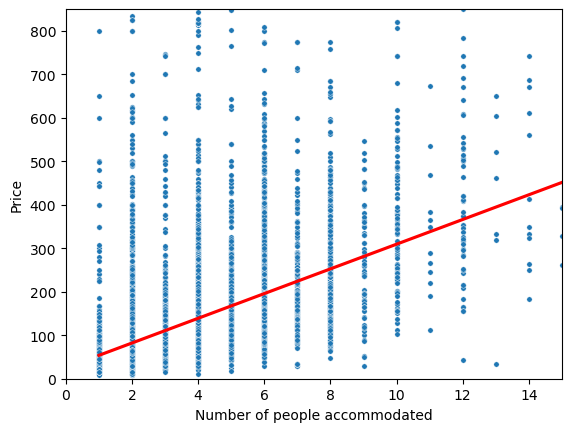

In [9]:
sns.scatterplot(data=df, x="n_accommodates", y="price", s=15)
sns.regplot(
    data=df, x="n_accommodates", y="price", color='red' ,scatter=False, ci=None
)
plt.ylim(0, 850)
plt.xlim(0, 15)
plt.xlabel("Number of people accommodated")
plt.ylabel("Price")
plt.show()

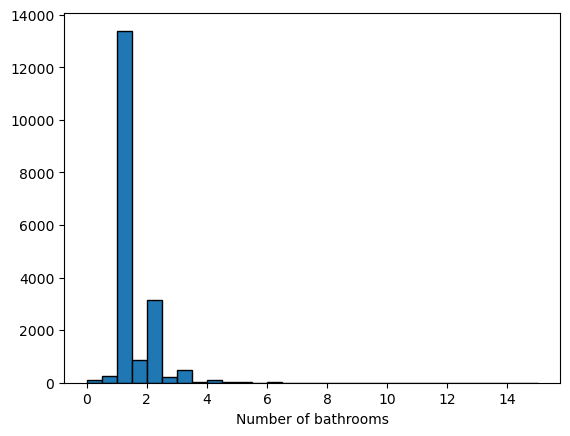

In [10]:
sns.histplot(df, x="n_bathrooms", binwidth=0.5, alpha=1)
plt.ylabel(None)
plt.xlabel("Number of bathrooms")
plt.show()

#### Create dummy variables

In [11]:
# DUMMY VARIABLES (binary)
print(df['host_is_superhost'].unique())

df['d_host_is_superhost'] = (df['host_is_superhost'] == 't').astype(int)
df['d_instant_bookable'] = (df['instant_bookable'] == 't').astype(int)
df['d_host_identity_verified'] = (df['host_identity_verified'] == 't').astype(int)

['f' nan 't']


#### Create days since first review variable (with last scraped and first review variables)

In [12]:
# DAYS SINCE FIRST REVIEW
df['n_days_since'] = (pd.to_datetime(df['last_scraped']) - pd.to_datetime(df['first_review'])).dt.days

#### Creating dummy variables for most essential amenities and creating a number of amenities variable

In [13]:
# AMENITIES EXTRACTION
# print(df['amenities'].unique())

def parse_amenities(x):
    if pd.isna(x): return []
    try: return json.loads(x)
    except: return re.findall(r'"([^"]*)"', x)

df['amenities_list'] = df['amenities'].apply(parse_amenities)

# Key amenities to extract
amenities_to_extract = [
    'Wifi', 'Air conditioning', 'Heating', 'Kitchen', 'Washer', 'Dryer',
    'TV', 'Hair dryer', 'Iron', 'Elevator', 'Free parking', 'Pool', 'Dishes and silverware',
    'Hot tub', 'Gym', 'Self check-in', 'Smoking allowed', 'Pets allowed', 'Hot water',
    'Coffee maker', 'Dishwasher', 'Microwave', 'Refrigerator', 'Balcony',
    'Fire extinguisher', 'Smoke alarm', 'Carbon monoxide alarm', 
    'Dedicated workspace', 'Essentials', 'Hangers', 'Bed linens'
]

for amenity in amenities_to_extract:
    col_name = 'd_' + re.sub(r'[^a-z0-9]', '', amenity.lower())
    df[col_name] = df['amenities_list'].apply(
        lambda x: int(any(amenity.lower() in a.lower() for a in x))
    )

df['n_amenities_count'] = df['amenities_list'].apply(len)


#### Created squared and log terms for accomodates, beds and number of reviews

In [14]:
# DERIVED FEATURES
# Squared and log terms
df['n_accommodates2'] = df['n_accommodates'] ** 2
df['ln_accommodates'] = np.log(df['n_accommodates'] + 1)
df['ln_accommodates2'] = df['ln_accommodates'] ** 2
df['ln_beds'] = np.log(df['n_beds'].fillna(1) + 1)
df['ln_number_of_reviews'] = np.log(df['n_number_of_reviews'] + 1)

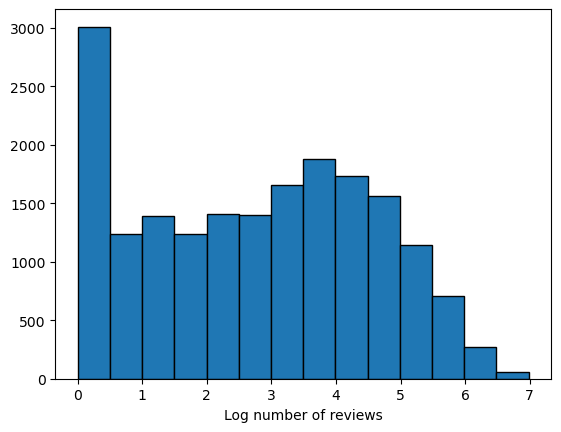

In [15]:
sns.histplot(df, x="ln_number_of_reviews", binwidth=0.5, alpha=1)
plt.ylabel(None)
plt.xlabel("Log number of reviews")
plt.show()

#### Create categorcical bins for number of bathrooms, number of reviews and minimum nights

In [16]:
# CATEGORICAL BINS
# Bathrooms: 0, 1, 2+, assume missing is 1 bathroom
df['f_bathroom'] = pd.cut(df['n_bathrooms'].fillna(1), bins=[-0.1, 0.9, 1.9, 100], labels=[0, 1, 2])

# Number of reviews: 0, 1-10, 11-50, 51+
df['f_number_of_reviews'] = pd.cut(df['n_number_of_reviews'], bins=[-0.1, 0.9, 10, 50, 10000], labels=[0, 1, 2, 3])

# Minimum nights: 1, 2, 3-7, 7+
df['f_minimum_nights'] = pd.cut(df['n_minimum_nights'], bins=[0, 1, 2, 7, 10000], labels=[1, 2, 3, 4])

#### Missing values: flag, impute with median if numerical, fill with mode if categorical, replace infinities with NaN

In [17]:
# HANDLE MISSING VALUES
# Impute numerical columns with median
for col in ['n_bathrooms', 'n_beds', 'n_bedrooms']:
    df[col] = df[col].fillna(df[col].median())

# Review-related: flag then impute
for col in ['n_days_since', 'n_review_scores_rating', 'n_reviews_per_month', 'p_host_response_rate']:
    flag_name = 'flag_' + col.replace('n_', '').replace('p_', '')
    df[flag_name] = df[col].isna().astype(int)
    df[col] = df[col].fillna(df[col].median())

# Recalculate log features after imputation
df['ln_beds'] = np.log(df['n_beds'] + 1)
df['ln_days_since'] = np.log(df['n_days_since'] + 1)
df['ln_days_since2'] = df['ln_days_since'] ** 2
df['ln_days_since3'] = df['ln_days_since'] ** 3
df['ln_review_scores_rating'] = np.log(df['n_review_scores_rating'] + 0.01)

# Replace infinities in numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
df[numeric_cols] = df[numeric_cols].fillna(0)

# Fill categorical NAs with mode
categorical_cols = df.select_dtypes(include=['category']).columns
for col in categorical_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

### Assemble final dataset with selected variables and save
**Variable Selection:**
- **Included variables**: ID and location identifiers, price (target), 6 categorical factors (property type, room type, neighbourhood, bathroom/review/nights bins), 22 numerical features (property characteristics, host metrics, review scores), 32 amenity dummies, and 4 missing value flags
- **Excluded variables**: Text fields (description, name), URLs, redundant IDs (host_id, scrape_id), calendar variables, license info, and raw columns already transformed into engineered features (original amenities JSON, bathrooms_text)

In [18]:
# SELECT FINAL COLUMNS
keep_cols = ['id', 'price', 'latitude', 'longitude']
keep_cols += [c for c in df.columns if c.startswith(('f_', 'n_', 'd_', 'ln_', 'p_', 'flag_'))]
keep_cols = list(dict.fromkeys(keep_cols))  # remove duplicates

data = df[keep_cols].copy()

print(f"\nFinal shape: {data.shape}")
print(f"Factors: {len([c for c in data.columns if c.startswith('f_')])}")
print(f"Numerical: {len([c for c in data.columns if c.startswith('n_') or c.startswith('ln_')])}")
print(f"Dummies: {len([c for c in data.columns if c.startswith('d_')])}")


Final shape: (18685, 71)
Factors: 6
Numerical: 22
Dummies: 34


In [19]:
# SAVE
data.to_csv(data_out + "airbnb_madrid_25q1_clean.csv", index=False)
print(f"\nSaved to: {data_out}airbnb_madrid_25q1_clean.csv")

# Quick summary
print("\n--- Price by room type ---")
print(data.groupby('f_room_type')['price'].agg(['mean', 'median', 'count']).round(1))


Saved to: C:\Users\borik\Desktop\Data-Analysis-3\assignment1\data\clean/airbnb_madrid_25q1_clean.csv

--- Price by room type ---
                  mean  median  count
f_room_type                          
Entire home/apt  140.3   113.5  13790
Private room      61.4    45.0   4847
Shared room       35.4    30.0     48
